In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
#os.chdir("/content/drive/MyDrive/共有フォルダ/実験")
os.chdir("/content/drive/MyDrive/松尾研究所/世界モデルと知能/最終課題/共有フォルダ/実験/")

Mounted at /content/drive


In [3]:
import os
import random
import numpy as np
from PIL import Image, ImageOps

import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from sklearn.preprocessing import minmax_scale

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
"""# 加工する関数
def process_image(imgs, k=None):

    batch_size = imgs.size(0)

    img = transforms.ToPILImage()(imgs[0])

    filter = np.zeros((batch_size, img.size[1], img.size[0], 3))
    for i in range(batch_size):
        n = random.randint(0, 2) if k == None else k
        filter[i, :, :, n] = 1.0

    filter_tensor = torch.from_numpy(filter.astype('float32')).permute(0, 3, 1, 2)

    ratio = 0.4
    imgs = imgs * ratio + filter_tensor * (1 - ratio)

    return imgs"""

def show_imgs(imgs, labels=None):
    num_images = len(imgs)

    normal_imgs = imgs

    fig = plt.figure(figsize=(16, 6))
    for i in range(num_images):

        ax = fig.add_subplot(2, num_images, i+1)
        ax.imshow(normal_imgs[i].permute(1, 2, 0))
        if labels is not None:
            ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
def torch_log(x: torch.Tensor) -> torch.Tensor:
    return torch.log(torch.clamp(x, min=1e-10))

# VAEモデル（別の構成）
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 15, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(15),

            nn.Conv2d(15, 18, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(18),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(18, 12, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.Conv2d(12, 12, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(12, 12, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.Flatten(),

            nn.Linear(12*7*7, z_dim**2),
            nn.BatchNorm1d(z_dim**2),
            nn.ReLU(),

            nn.Linear(z_dim**2, z_dim * 2),
            nn.BatchNorm1d(z_dim * 2),
            nn.ReLU(),
        )

        self.enc_mean = nn.Linear(z_dim * 2, z_dim)
        self.enc_std = nn.Linear(z_dim * 2, z_dim)

        # Decoder
        self.dec_lin = nn.Linear(z_dim, z_dim * 2)
        self.dec = nn.Sequential(
            nn.Linear(z_dim*2, z_dim**2),
            nn.BatchNorm1d(z_dim**2),
            nn.ReLU(),

            nn.Linear(z_dim**2, 12*7*7),
            nn.BatchNorm1d(12*7*7),
            nn.ReLU(),

            nn.Unflatten(1, (12, 7, 7)),

            nn.ConvTranspose2d(12, 12, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(12, 12, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),

            nn.ConvTranspose2d(12, 18, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Upsample(scale_factor=2),

            nn.ConvTranspose2d(18, 18, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(18),

            nn.ConvTranspose2d(18, 15, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(15, 3, kernel_size=1, stride=1, padding=0),

            nn.Sigmoid()
        )

    def encoder(self, x):
        h = self.enc(x)
        mean = self.enc_mean(h)
        std = F.softplus(self.enc_std(h))

        return mean, std

    def decoder(self, z):
        h = self.dec_lin(z)
        x = self.dec(h)
        return x

    def sample_z(self, mean: torch.Tensor, std: torch.Tensor):
        if self.training:
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def loss(self, x: torch.Tensor):
        mean, std = self.encoder(x)

        z = self.sample_z(mean, std)
        y = self.decoder(z)

        x_flat = x.view(x.size(0), -1)
        y_flat = y.view(y.size(0), -1)
        KL_loss = nn.KLDivLoss(reduction='batchmean')(mean, std)
        reconstruction_loss = nn.MSELoss()(x_flat, y_flat)

        return -KL_loss, reconstruction_loss, y, z

In [6]:
with open('./losses.json') as f:
    losses = json.load(f)

with open('./data-0.8.json') as f:
    data = json.load(f)

model = VAE(z_dim=36).to(device)
model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

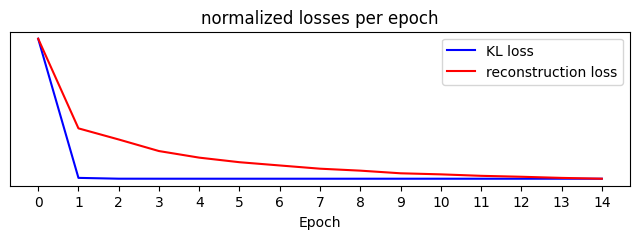

In [ ]:
# 学習過程の可視化
KL_loss = minmax_scale(losses["KL"])
reconstruction_loss = minmax_scale(losses["reconstruction"])

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(KL_loss, color="blue", label="KL loss")
ax.plot(reconstruction_loss, color="red", label="reconstruction loss")
ax.yaxis.set_visible(False)
ax.set_yticks([])
ax.set_xticks(np.arange(0, len(KL_loss), 1))
ax.set_xlabel("Epoch")
ax.legend()
plt.title("normalized losses per epoch")
plt.show()

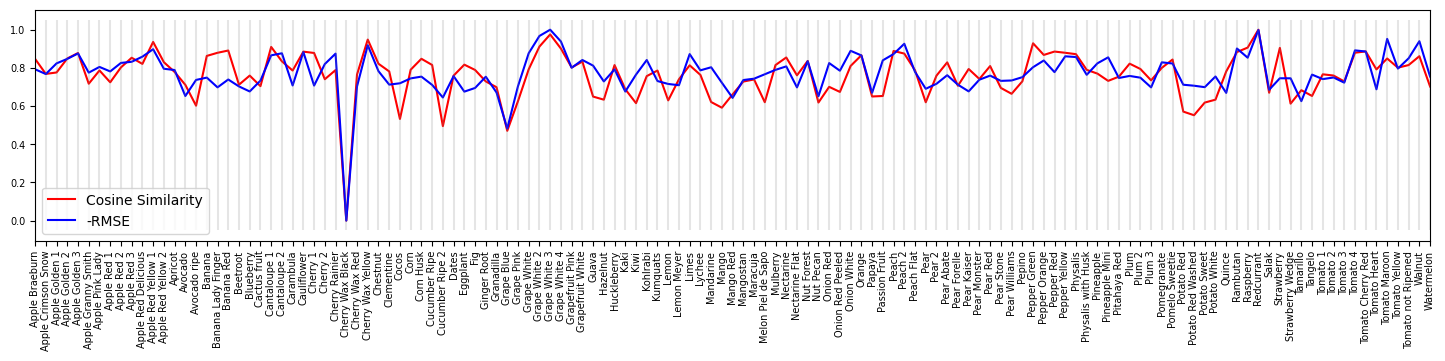

In [17]:
# 各ラベルごとに潜在変数の距離を可視化
# コサイン類似度とRMSEの評価指標にて距離を計算
# RMSEは距離が小さい方が上になるように、y軸を反転

rmse_scores = {}
cosine_similarities = {}
labels = []
for i, label in enumerate(data):
    class_data = data[label]
    normal_z = torch.tensor(class_data["normal"])
    processed_z = torch.tensor(class_data["processed"])

    diff = normal_z - processed_z
    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
    rmse_scores[label] = -rmse.item()

    similarity = F.cosine_similarity(normal_z, processed_z)
    cosine_similarities[label] = similarity.mean()

    labels.append(label)

fig, ax = plt.subplots(figsize=(18, 3))

v1 = minmax_scale(list(cosine_similarities.values()))
v2 = minmax_scale(list(rmse_scores.values()))

ax.plot(labels, v1, color="red", label="Cosine Similarity")
ax.plot(labels, v2, color="blue", label="-RMSE")

# グラフ上部に縦線を引く
ylim = ax.get_ylim()
ax.vlines(range(len(labels)), ylim[0], ylim[1], linestyles="solid", color="gray", alpha=0.2)

ax.tick_params(labelsize=7)

ax.set_xticklabels(labels, rotation=90)
plt.xlim([0, len(labels)-1])

ax.legend()

plt.show()

# 分割したグラフ

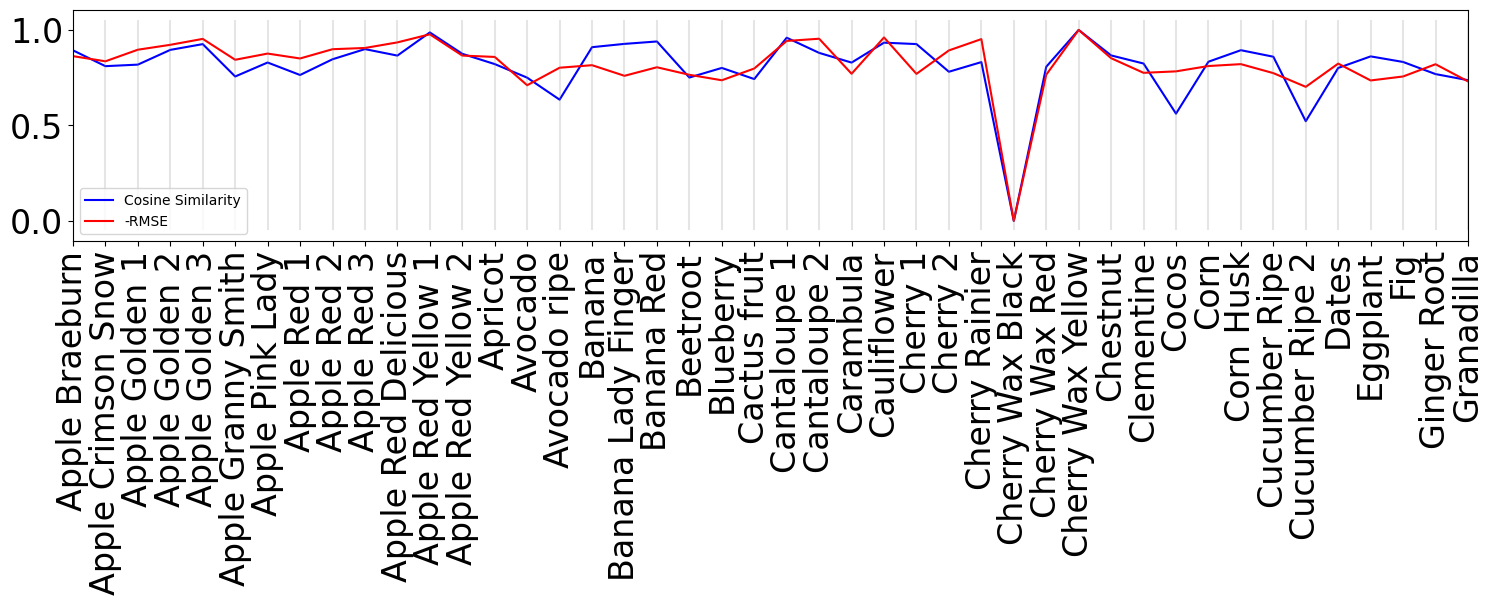

In [ ]:
rmse_scores = {}
cosine_similarities = {}
labels = []
for i, label in enumerate(data):
    if i < len(data.keys())/3:
        class_data = data[label]
        normal_z = torch.tensor(class_data["normal"])
        processed_z = torch.tensor(class_data["processed"])

        diff = normal_z - processed_z
        rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
        rmse_scores[label] = -rmse.item()

        similarity = F.cosine_similarity(normal_z, processed_z)
        cosine_similarities[label] = similarity.mean()

        labels.append(label)

fig, ax = plt.subplots(figsize=(18, 3))

v1 = minmax_scale(list(cosine_similarities.values()))
v2 = minmax_scale(list(rmse_scores.values()))

ax.plot(labels, v1, color="blue", label="Cosine Similarity")
ax.plot(labels, v2, color="red", label="-RMSE")

# グラフ上部に縦線を引く
ylim = ax.get_ylim()
ax.vlines(range(len(labels)), ylim[0], ylim[1], linestyles="solid", color="gray", alpha=0.2)

ax.tick_params(labelsize=24)

ax.set_xticklabels(labels, rotation=90)
plt.xlim([0, len(labels)-1])

ax.legend()

plt.show()

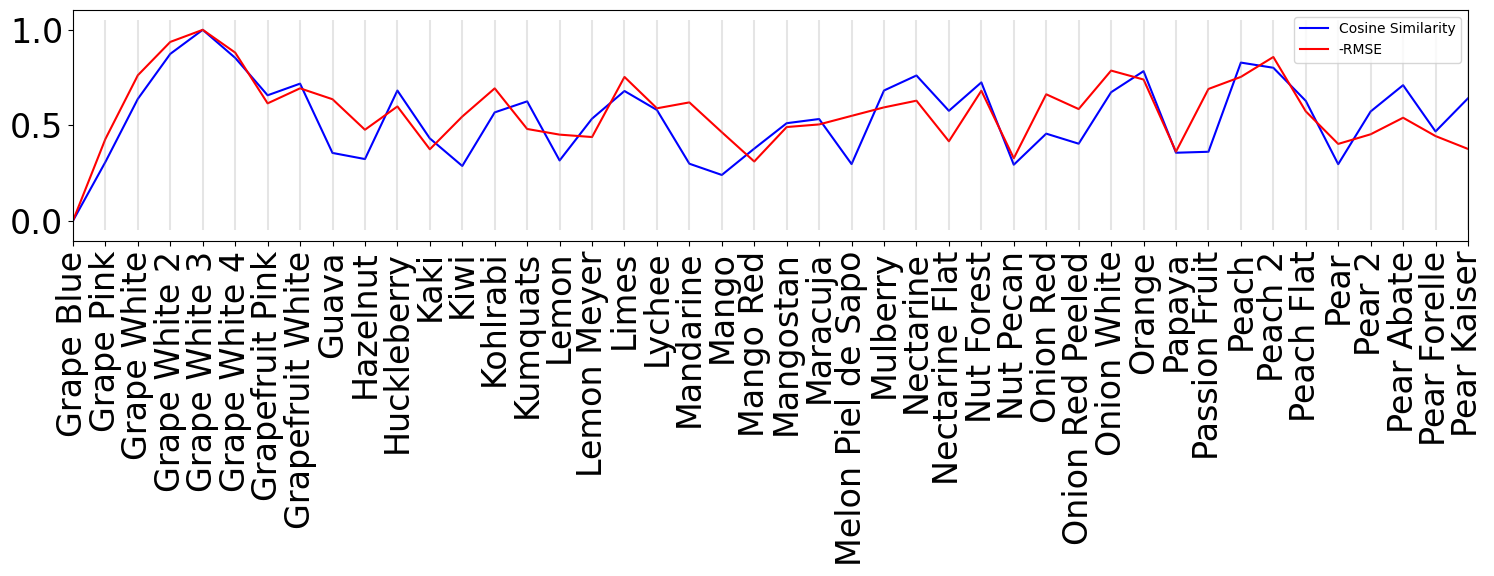

In [ ]:
# 各ラベルごとに潜在変数の距離を可視化
# コサイン類似度とRMSEの評価指標にて距離を計算
# RMSEは距離が小さい方が上になるように、y軸を反転

rmse_scores = {}
cosine_similarities = {}
labels = []
for i, label in enumerate(data):
    if len(data.keys())/3 < i < 2*len(data.keys())/3:
        class_data = data[label]
        normal_z = torch.tensor(class_data["normal"])
        processed_z = torch.tensor(class_data["processed"])

        diff = normal_z - processed_z
        rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
        rmse_scores[label] = -rmse.item()

        similarity = F.cosine_similarity(normal_z, processed_z)
        cosine_similarities[label] = similarity.mean()

        labels.append(label)

fig, ax = plt.subplots(figsize=(18, 3))

v1 = minmax_scale(list(cosine_similarities.values()))
v2 = minmax_scale(list(rmse_scores.values()))

ax.plot(labels, v1, color="blue", label="Cosine Similarity")
ax.plot(labels, v2, color="red", label="-RMSE")

# グラフ上部に縦線を引く
ylim = ax.get_ylim()
ax.vlines(range(len(labels)), ylim[0], ylim[1], linestyles="solid", color="gray", alpha=0.2)

ax.tick_params(labelsize=24)

ax.set_xticklabels(labels, rotation=90)
plt.xlim([0, len(labels)-1])

ax.legend()

plt.show()

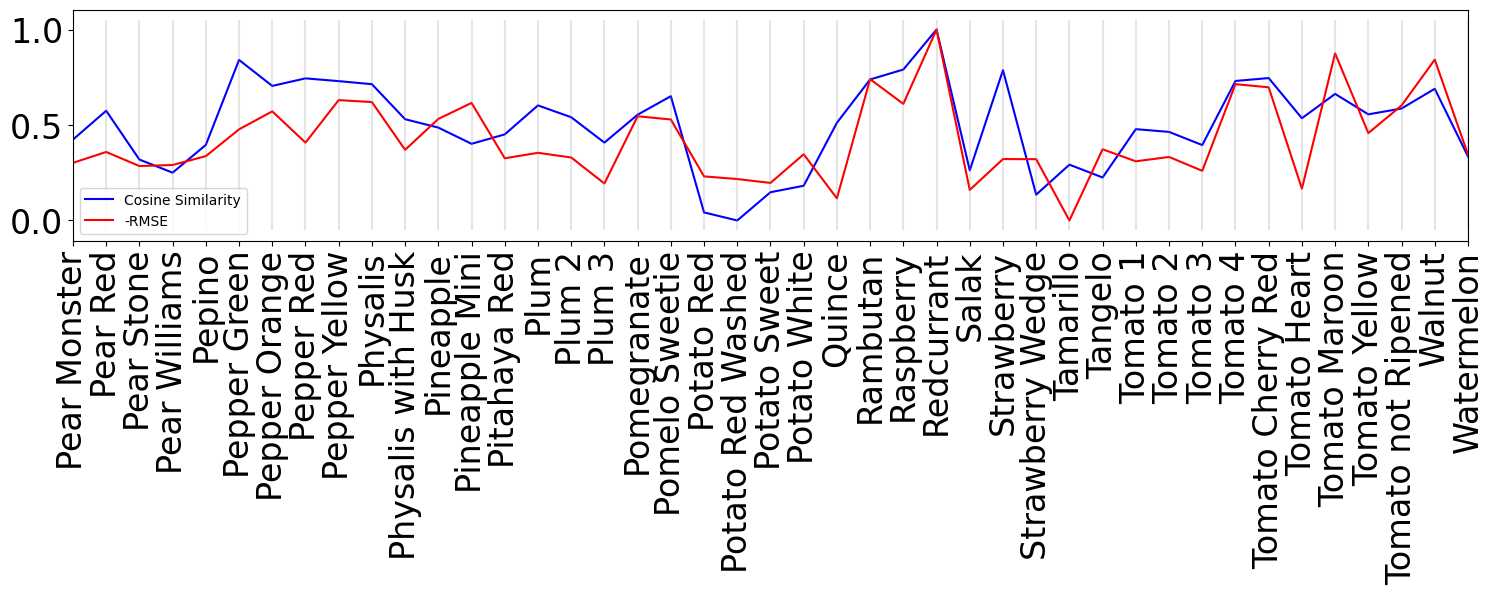

In [ ]:
# 各ラベルごとに潜在変数の距離を可視化
# コサイン類似度とRMSEの評価指標にて距離を計算
# RMSEは距離が小さい方が上になるように、y軸を反転

rmse_scores = {}
cosine_similarities = {}
labels = []
for i, label in enumerate(data):
    if 2*len(data.keys())/3 < i:
        class_data = data[label]
        normal_z = torch.tensor(class_data["normal"])
        processed_z = torch.tensor(class_data["processed"])

        diff = normal_z - processed_z
        rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
        rmse_scores[label] = -rmse.item()

        similarity = F.cosine_similarity(normal_z, processed_z)
        cosine_similarities[label] = similarity.mean()

        labels.append(label)

fig, ax = plt.subplots(figsize=(18, 3))

v1 = minmax_scale(list(cosine_similarities.values()))
v2 = minmax_scale(list(rmse_scores.values()))

ax.plot(labels, v1, color="blue", label="Cosine Similarity")
ax.plot(labels, v2, color="red", label="-RMSE")

# グラフ上部に縦線を引く
ylim = ax.get_ylim()
ax.vlines(range(len(labels)), ylim[0], ylim[1], linestyles="solid", color="gray", alpha=0.2)

ax.tick_params(labelsize=24)

ax.set_xticklabels(labels, rotation=90)
plt.xlim([0, len(labels)-1])

ax.legend()

plt.show()

# 成分ごと

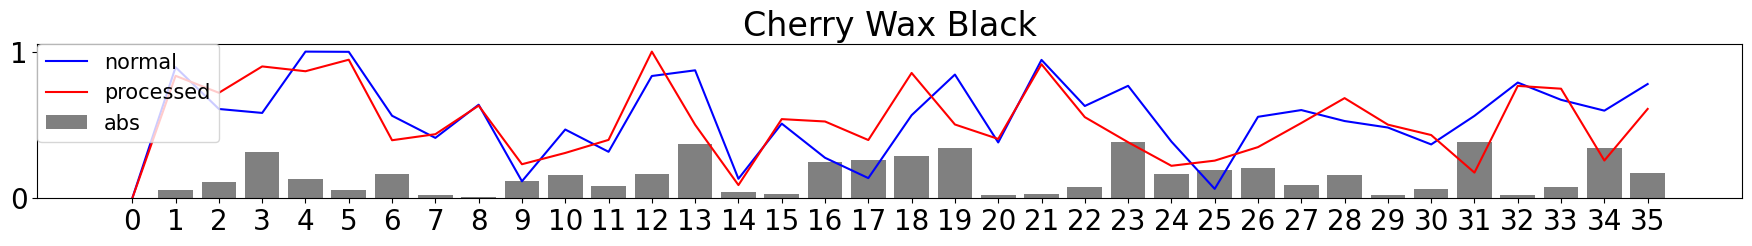

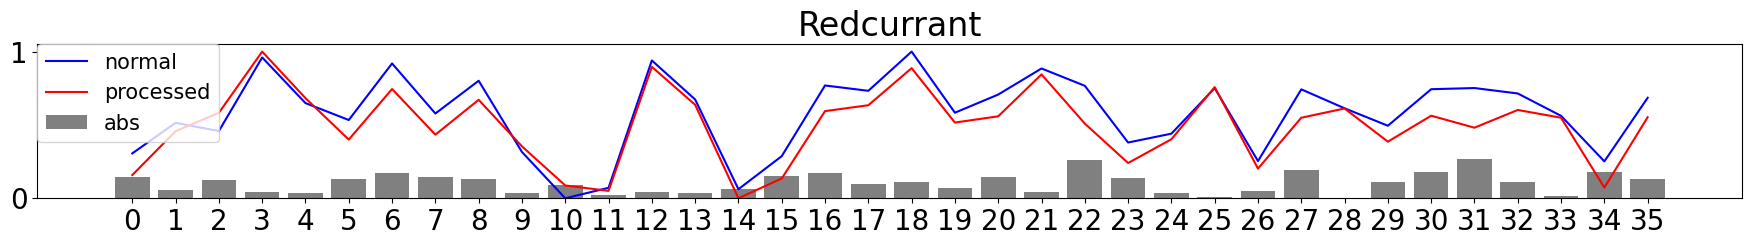

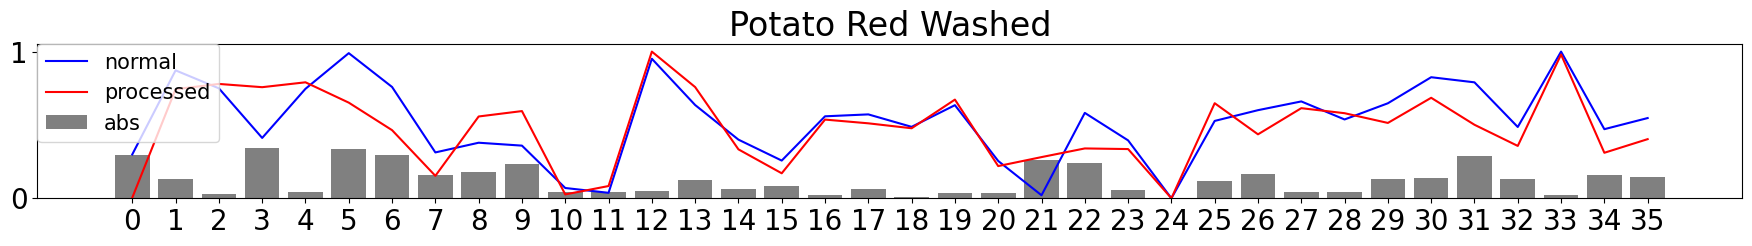

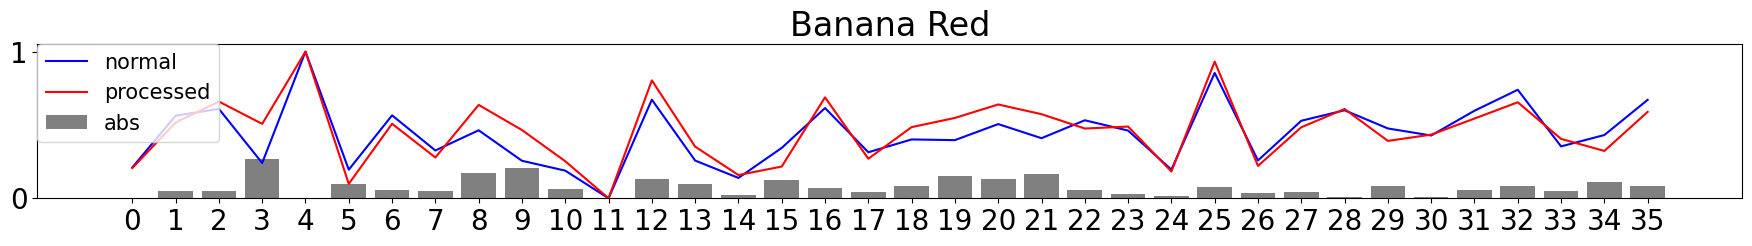

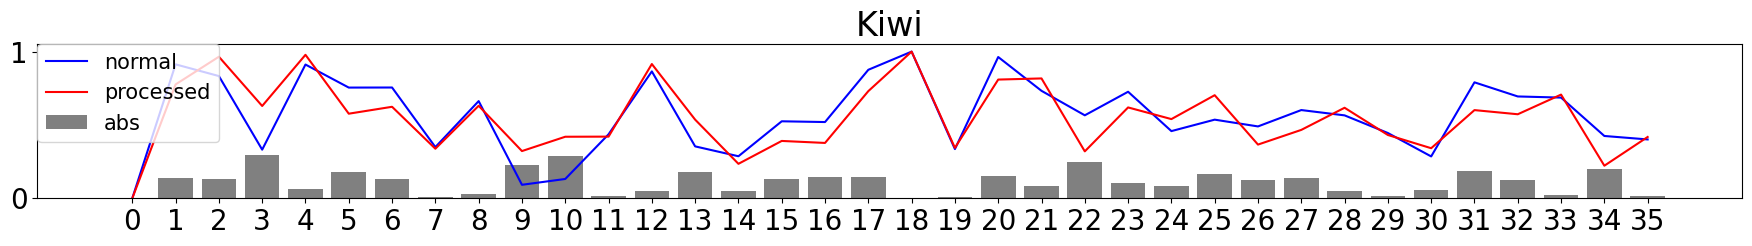

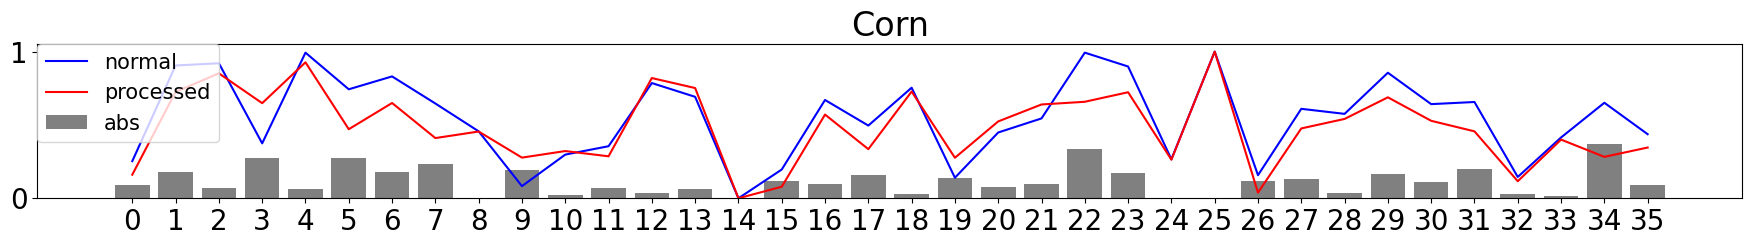

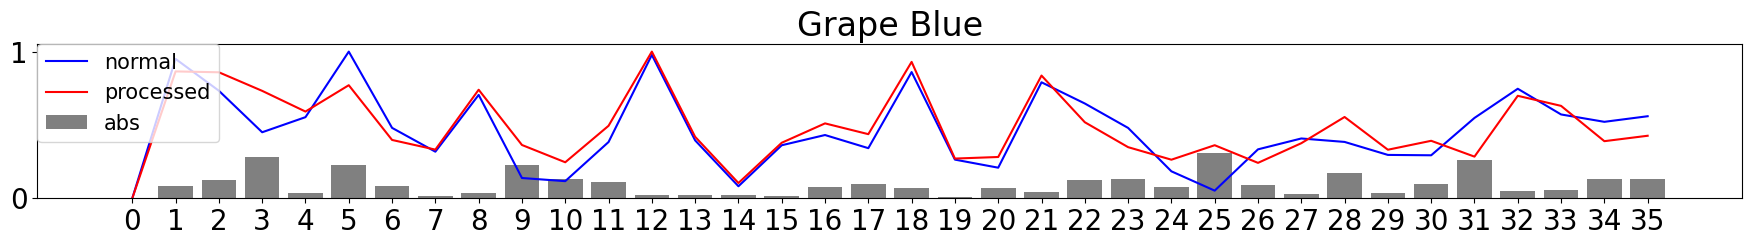

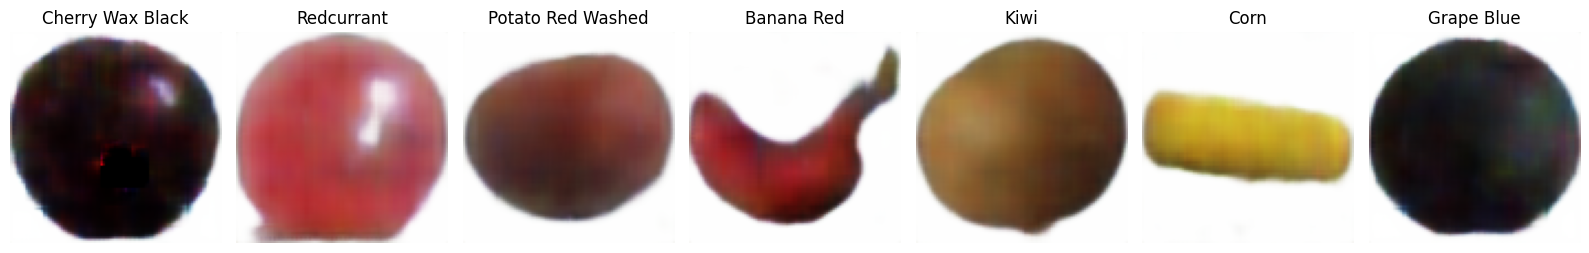

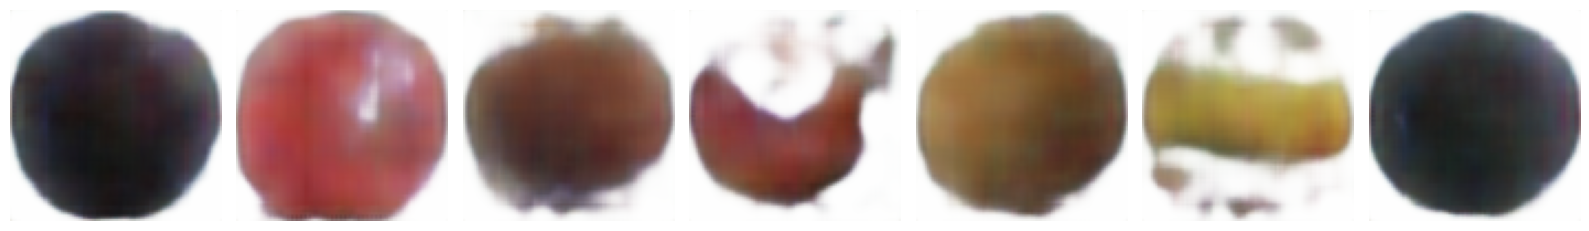

In [18]:
# 各画像の成分ごとの違いを可視化
labels = [
    "Cherry Wax Black", # 最も低い
    "Redcurrant", # 最も高い
    "Potato Red Washed", # C < R
    "Banana Red", # C > R
    "Kiwi", # 普通くらい
    "Corn", # 普通くらい
    "Grape Blue", # 低い方
]

abses = []
normals, processeds = [], []
model.eval()
with torch.no_grad():
    for target_label in labels:
        target_data = data[target_label]
        fig, ax = plt.subplots(figsize=(22, 2))
        v1 = minmax_scale(target_data["normal"][0])
        v2 = minmax_scale(target_data["processed"][0])
        ax.plot(v1, color="blue", label="normal")
        ax.plot(v2, color="red", label="processed")
        diff_abs = [abs(a - b) for a, b in zip(v1, v2)]
        ax.bar(range(len(diff_abs)), diff_abs, color="gray", label="abs")
        abses.append(diff_abs)
        ax.set_xticks(np.arange(0, len(v1), 1))
        ax.tick_params(labelsize=20)
        plt.title(target_label, fontsize=24)
        ax.legend(bbox_to_anchor=(0, 1),
            loc='upper left',
            borderaxespad=0,
            fontsize=15,
            ncol=1)
        plt.show()

        # 画像表示
        normal_z = torch.tensor(target_data["normal"][:5]).to(device)
        processed_z = torch.tensor(target_data["processed"][:5]).to(device)

        normal_reconstructed = model.decoder(normal_z)
        normal_reconstructed = normal_reconstructed.cpu().detach()
        normals.append(normal_reconstructed[4])

        processed_reconstructed = model.decoder(processed_z)
        processed_reconstructed = processed_reconstructed.cpu().detach()
        processeds.append(processed_reconstructed[4])

show_imgs(torch.stack(normals), labels)
show_imgs(torch.stack(processeds))

In [11]:
# 全てのクラスの再構成結果を表示する

import itertools

keys = data.keys()
labels_group = itertools.zip_longest(*[iter(keys)]*10)

for group in labels_group:

    abses = []
    normals, processeds = [], []
    model.eval()
    with torch.no_grad():
        for target_label in group:
            target_data = data[target_label]
            # 画像表示
            processed_z = torch.tensor(target_data["processed"][:5]).to(device)

            processed_reconstructed = model.decoder(processed_z)
            processed_reconstructed = processed_reconstructed.cpu().detach()
            processeds.append(processed_reconstructed[4])

    show_imgs(torch.stack(processeds), group)

Output hidden; open in https://colab.research.google.com to view.

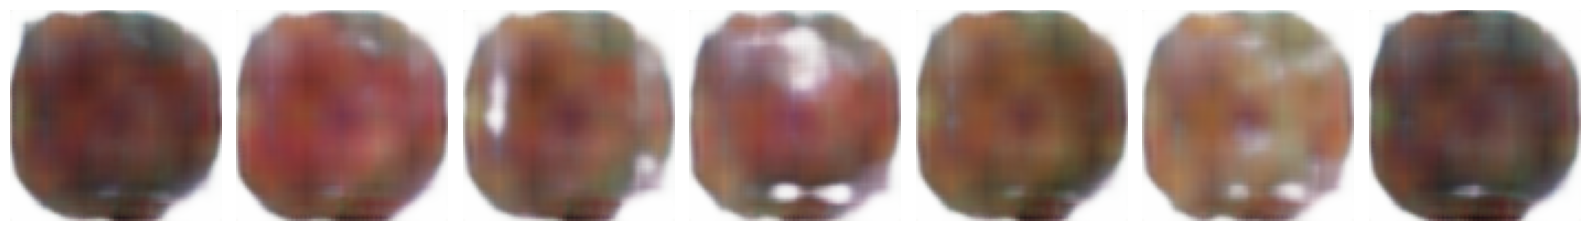

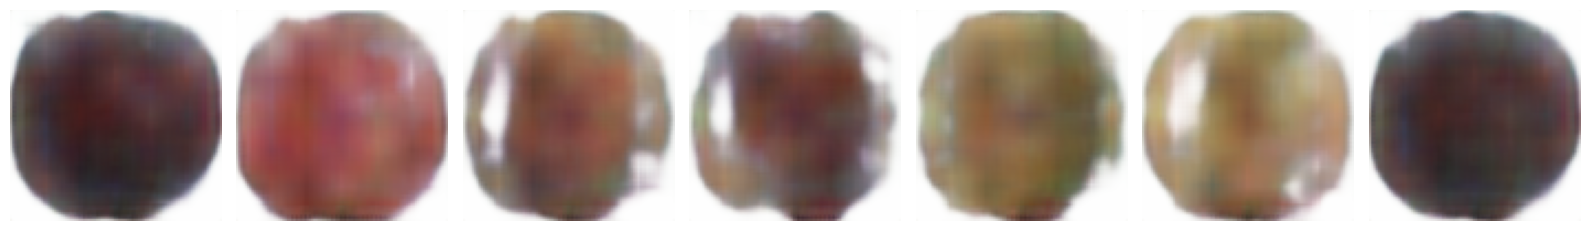

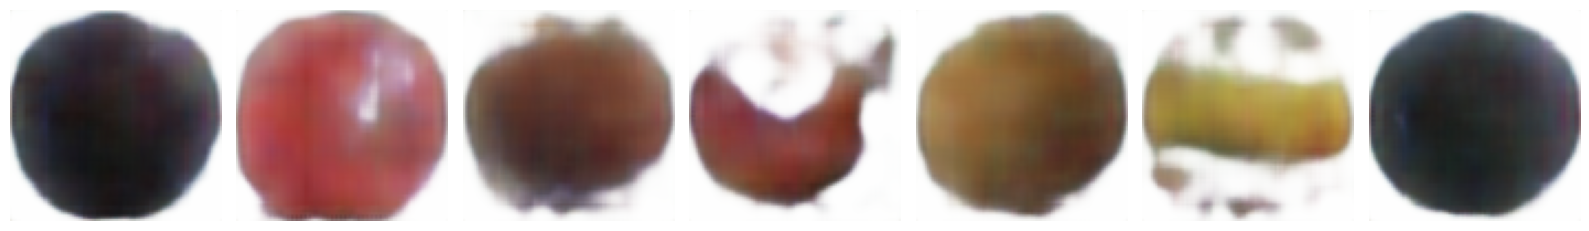

In [6]:
# 錯視加工の比率ごとに表示
labels = [
    "Cherry Wax Black", # 最も低い
    "Redcurrant", # 最も高い
    "Potato Red Washed", # C < R
    "Banana Red", # C > R
    "Kiwi", # 普通くらい
    "Corn", # 普通くらい
    "Grape Blue", # 低い方
]

for ratio in [0.4, 0.6, 0.8]:
    with open(f'./data-{ratio}.json') as f:
        data = json.load(f)

    abses = []
    normals, processeds = [], []
    model.eval()
    with torch.no_grad():
        for target_label in labels:
            target_data = data[target_label]
            # 画像表示
            processed_z = torch.tensor(target_data["processed"][:5]).to(device)

            processed_reconstructed = model.decoder(processed_z)
            processed_reconstructed = processed_reconstructed.cpu().detach()
            processeds.append(processed_reconstructed[4])

    show_imgs(torch.stack(processeds),)

<BarContainer object of 36 artists>

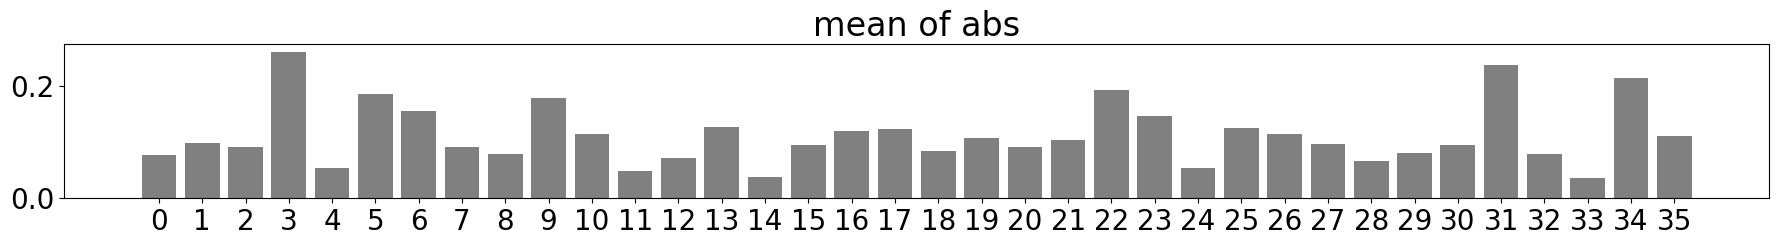

In [ ]:
# 平均をグラフで描画
abses_mean = np.mean(abses, axis=0)
fig, ax = plt.subplots(figsize=(22, 2))
ax.set_xticks(np.arange(0, len(abses_mean), 1))
ax.tick_params(labelsize=20)
plt.title("mean of abs", fontsize=24)
ax.bar(range(len(abses_mean)), abses_mean, color="gray", label="abs")

# 再構成

In [ ]:
# リンゴとバナナの潜在変数
z1 = np.array(random.choice(data["Apple Red 1"]["normal"]))
z2 = np.array(random.choice(data["Banana"]["normal"]))

# 変化の軌跡を生成
num_steps = 20
zs = [z1]
for alpha in np.linspace(0, 1, num_steps):
    zs.append(z1 + alpha * (z2 - z1))
zs = torch.tensor(zs)

images = model.decoder(zs.float().to(device))
images = images.cpu().detach().numpy()

images = images.transpose(0, 2, 3, 1)

grid_image = np.concatenate(images, axis=1)
plt.figure(figsize=(20, 6))
plt.imshow(grid_image)
plt.tight_layout()
plt.axis('off')
plt.title('Apple -> Banana')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# リンゴとバナナの潜在変数
z1 = np.array(random.choice(data["Tangelo"]["normal"]))
z2 = np.array(random.choice(data["Banana"]["normal"]))
z3 = np.array(random.choice(data["Tomato 2"]["normal"]))

z1_2 = z2 - z1
z1_3 = z3 - z1

# 変化の軌跡を生成
size = 10
for a in np.linspace(0, 1, size):
    zs = []
    for b in np.linspace(0, 1, size):
        zs.append(z1 + a*z1_2 + b*z1_3)
    zs = torch.tensor(zs)

    images = model.decoder(zs.float().to(device))
    images = images.cpu().detach().numpy()

    images = images.transpose(0, 2, 3, 1)

    grid_image = np.concatenate(images, axis=1)
    plt.figure(figsize=(20, 6))
    plt.imshow(grid_image)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.